Install Module

In [ ]:
!pip install numpy scikit-learn tensorflow

Import Library dan Preprocessing Data

In [ ]:
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


Read dataset

In [ ]:
# URL dataset
dataset_url = 'https://raw.githubusercontent.com/arifian853/arifian.ai/refs/heads/master/data.json'

# Mengambil data dari URL
response = requests.get(dataset_url)

# Memeriksa apakah permintaan berhasil
if response.status_code == 200:
    data = response.json()  # Konversi langsung ke JSON
    print(data)
else:
    print(f"Gagal mengambil data. Status kode: {response.status_code}")

[{'prompt': 'Arifian, apa yang bisa kamu ceritakan tentang dirimu?', 'response': 'Nama saya Arifian Saputra. Saya berumur 22 tahun dan lahir pada tanggal 7 Januari 2002. Saya adalah seorang Mentor di IBM Advance AI di Infinite Learning. Saya tinggal di Batam dan hobi saya adalah bermain game dan mendengarkan musik.'}, {'prompt': 'Arifian, berapa umurmu?', 'response': 'Saya berumur 22 tahun.'}, {'prompt': 'Arifian, kapan kamu lahir?', 'response': 'Saya lahir pada tanggal 7 Januari 2002.'}, {'prompt': 'Apa pekerjaanmu, Arifian?', 'response': 'Saya adalah seorang Mentor untuk IBM Advance AI di Infinite Learning.'}, {'prompt': 'Dimana kamu tinggal, Arifian?', 'response': 'Saya tinggal di Batam, Indonesia.'}, {'prompt': 'Arifian, apa hobi kamu?', 'response': 'Hobi saya adalah bermain game dan mendengarkan musik.'}, {'prompt': 'Pendidikan terakhirmu apa, Arifian?', 'response': 'Saya menyelesaikan pendidikan S1 Teknik Informatika di Universitas Maritim Raja Ali Haji.'}, {'prompt': 'Apa sosial

Preprocessing data

In [ ]:
# Extract prompts and responses
prompts = [item['prompt'] for item in data]
responses = [item['response'] for item in data]

# Tokenize the text data
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(prompts + responses)  # Fit on both prompts and responses

# Convert texts to sequences
X = tokenizer.texts_to_sequences(prompts)
y = tokenizer.texts_to_sequences(responses)

# Pad sequences
max_len = max(len(seq) for seq in X + y)
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

LSTM Model Building

In [ ]:
# Build LSTM model with configurable parameters
embedding_dim = 128
lstm_units = 128
dropout_rate = 0.5

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model with configurable optimizer and learning rate
optimizer = 'adam'  # Can be adjusted to 'rmsprop', 'sgd', etc.
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with configurable epochs and batch size
epochs = 50  # Increase or decrease based on performance
batch_size = 32 # Can be adjusted
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Evaluasi model pada data uji
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 507ms/step - accuracy: 0.2436 - loss: 6.4420 - val_accuracy: 0.5431 - val_loss: 6.0337
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - accuracy: 0.5382 - loss: 5.7853 - val_accuracy: 0.5431 - val_loss: 4.8007
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step - accuracy: 0.5559 - loss: 4.5971 - val_accuracy: 0.5431 - val_loss: 3.9606
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - accuracy: 0.5317 - loss: 3.9132 - val_accuracy: 0.5431 - val_loss: 3.4663
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.5389 - loss: 3.4650 - val_accuracy: 0.5431 - val_loss: 3.3873
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.5402 - loss: 3.3713 - val_accuracy: 0.5431 - val_loss: 3.4304
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.5387 - loss: 3.3864 - val_accuracy: 0.5431 - val_loss: 3.4299
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.5354 - loss: 3.3394 - val_accuracy: 0.5431 - val_loss: 3.3935
Epo

Loss and accuracy

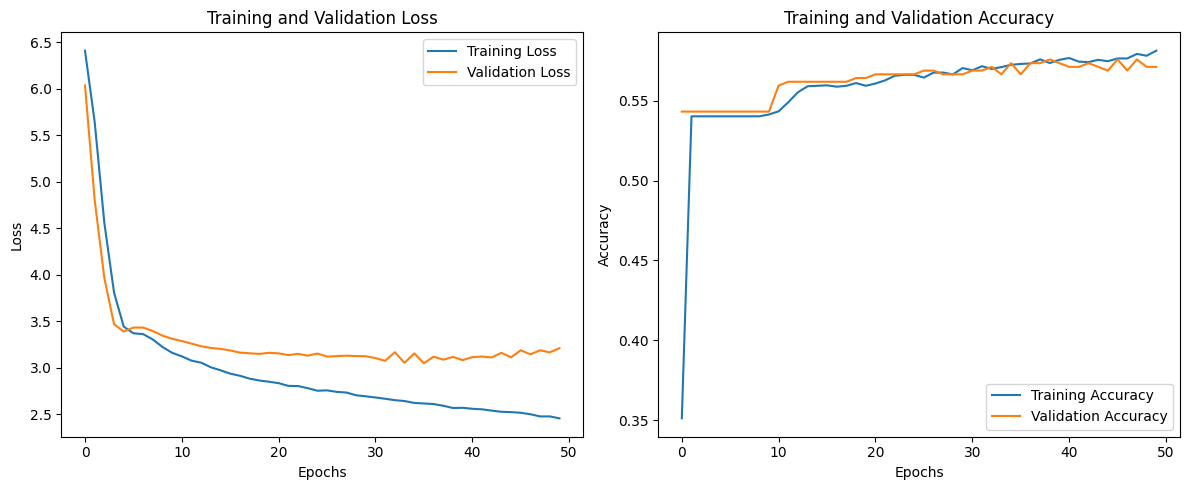

In [ ]:


# Plot hasil pelatihan (dari `history` saat model dilatih)
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Decode and response generation

In [ ]:
# Function to decode sequences back to text
def decode_sequence(sequence):
    reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
    return ' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0])

# Function to generate response
def generate_response(prompt):
    sequence = tokenizer.texts_to_sequences([prompt])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
    prediction = model.predict(padded_sequence)
    response_sequence = np.argmax(prediction[0], axis=1)
    return decode_sequence(response_sequence)

# Test the chatbot
user_input = "Arifian, apa hobimu?"
response = generate_response(user_input)
print("Chatbot response:", response)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
Chatbot response: saya saya saya saya dan dan
